# Data Analysis Final Report

Jethro Lee, Dylan Li, Daphne Li, Shreya Rajeswaran

## Executive Summary



The goal for our program is to understand how different features of songs potentially contribute to genre labeling on Spotify. Our [results](#PCA) revealed that genre labels heavily overlap, indicating that songs often share qualities between genres. We also used [clustering](#Clustering) in hopes of visualizing natural grouping by genre through machine learning. However, by taking a look at our results, we found that there were no distinct groups that formed. Finally, we created a [classifier](#Classifier) in order to predict songs based on their measured characteristics. With an accuracy score of about 49%, our classifier works relatively well but may confuse genres that share heavy overlap in terms of traits. 

## Introduction


Our motivation was to understand more about the connection between the features of a Spotify track and its genre. The purpose of a genre is to classify songs of a similar nature, so we expected to find a pattern across each song in a given genre. This connection between song features and genres will help us gain information on if Spotify’s metrics can be used for classification, and we wanted to use this information to predict the genre of new songs. We additionally wanted to cluster the data and see if natural genre groupings would be emulated.

We wanted to address how many people complain that Spotify is poor when it comes to curating song recommendations for its users. Many individuals feel that Spotify does not suggest songs that pertain to our interests. Hence, users have to go through the trouble of skipping songs they dislike, changing their music habits, and building their own playlists in hopes that Spotify’s algorithms can finally produce a recommended playlist that they can enjoy. Listening to a few songs can sometimes drastically alter Spotify's song recommendations in a negative way. In-playlist recommendations can be limited to songs from the same artists and country. Users also cannot erase their search history, so Spotify doesn’t account well for users’ evolving music tastes. Based on these issues, Spotify may not classify songs in the best way possible. Therefore, we will investigate the matter by designing a machine that categorizes songs based on how Spotify quantitatively analyzes them. 


Motivating Sources:
- [Why are recommendations so terrible](https://community.spotify.com/t5/iOS-iPhone-iPad/Why-are-recommendations-so-terrible/td-p/4769866)
- [Bad music recommendation](https://community.spotify.com/t5/iOS-iPhone-iPad/Bad-music-recommendation/td-p/5038061)
- [How to unf*ck the recommendation algorithm?](https://www.reddit.com/r/spotify/comments/s61vgb/how_to_unfuck_the_recommendation_algorithm/)
- [If Your Discover Weekly Playlist Sucks, Try This](https://lifehacker.com/if-your-discover-weekly-playlist-sucks-try-this-1823436104)
- [Terrible Recommendations](https://www.reddit.com/r/spotify/comments/k3r256/terrible_recommendations/)
- [What Makes a Spotify Song Popular?](https://d-soccerstar.medium.com/what-makes-a-spotify-song-popular-99b08da6e735)
- [Breaking Spotify’s Algorithm of Music Genre Classification!](https://towardsdatascience.com/breaking-spotifys-algorithm-of-music-genre-classification-31ecf8453af1)

We'll cluster a set of Spotify tracks into categories based on how similar they are based on Spotify's algorithms to see whether there are discrepancies between Spotify's genre classifications and its quantitative analysis of a song. We'll also use a KNN classifier prediction system that predicts the genre of a song based on its features (e.g. danceability, energy, acousticness, etc.) to observe if Spotify’s way of assigning a genre to a song may be too ambiguous.

## Data Description

For this project, we used a Spotify track dataset from [Kaggle,](https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset) which was derived from the Spotify API. It contains basic track information such as name and artist. It also includes additional data features describing qualities of the song such as valence, which measures the positive (or negative) emotional feelings given off by the song in question. These features will serve as the focus of our analysis. The only potential problem with collecting this data is that the CSV file is so large, so it would take a long time for Google Colab to process all of our data as we keep running the project file.

### Obtaining and cleaning data

This project will utilize Spotify API data gathered from [Kaggle.](https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset)

We will accomplish this task using the following steps:
- convert csv to df
    - use pandas to read in csv and convert it to a dataframe
- clean spotify data
    - In the pandas dataframe, if a song contains a missing value for a feature (e.g. valence, tempo, artist), then that song should be cleaned out of the dataframe

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from copy import copy
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import plotly.express as px
from scipy.spatial import distance
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [ ]:
# read in the data (must have csv downloaded from Kaggle)
df_spotify = pd.read_csv('spotify_stats.csv', index_col=0)

df_spotify.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [ ]:
# filter out tracks with empty values
df_clean = df_spotify.dropna(how='any')

df_clean.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


### Visualizations:

After cleaning, the first thing we wanted to do was to visualize the overall data to understand the trends and patterns in it.

#### Visualization 1: Boxplot distribution of traits

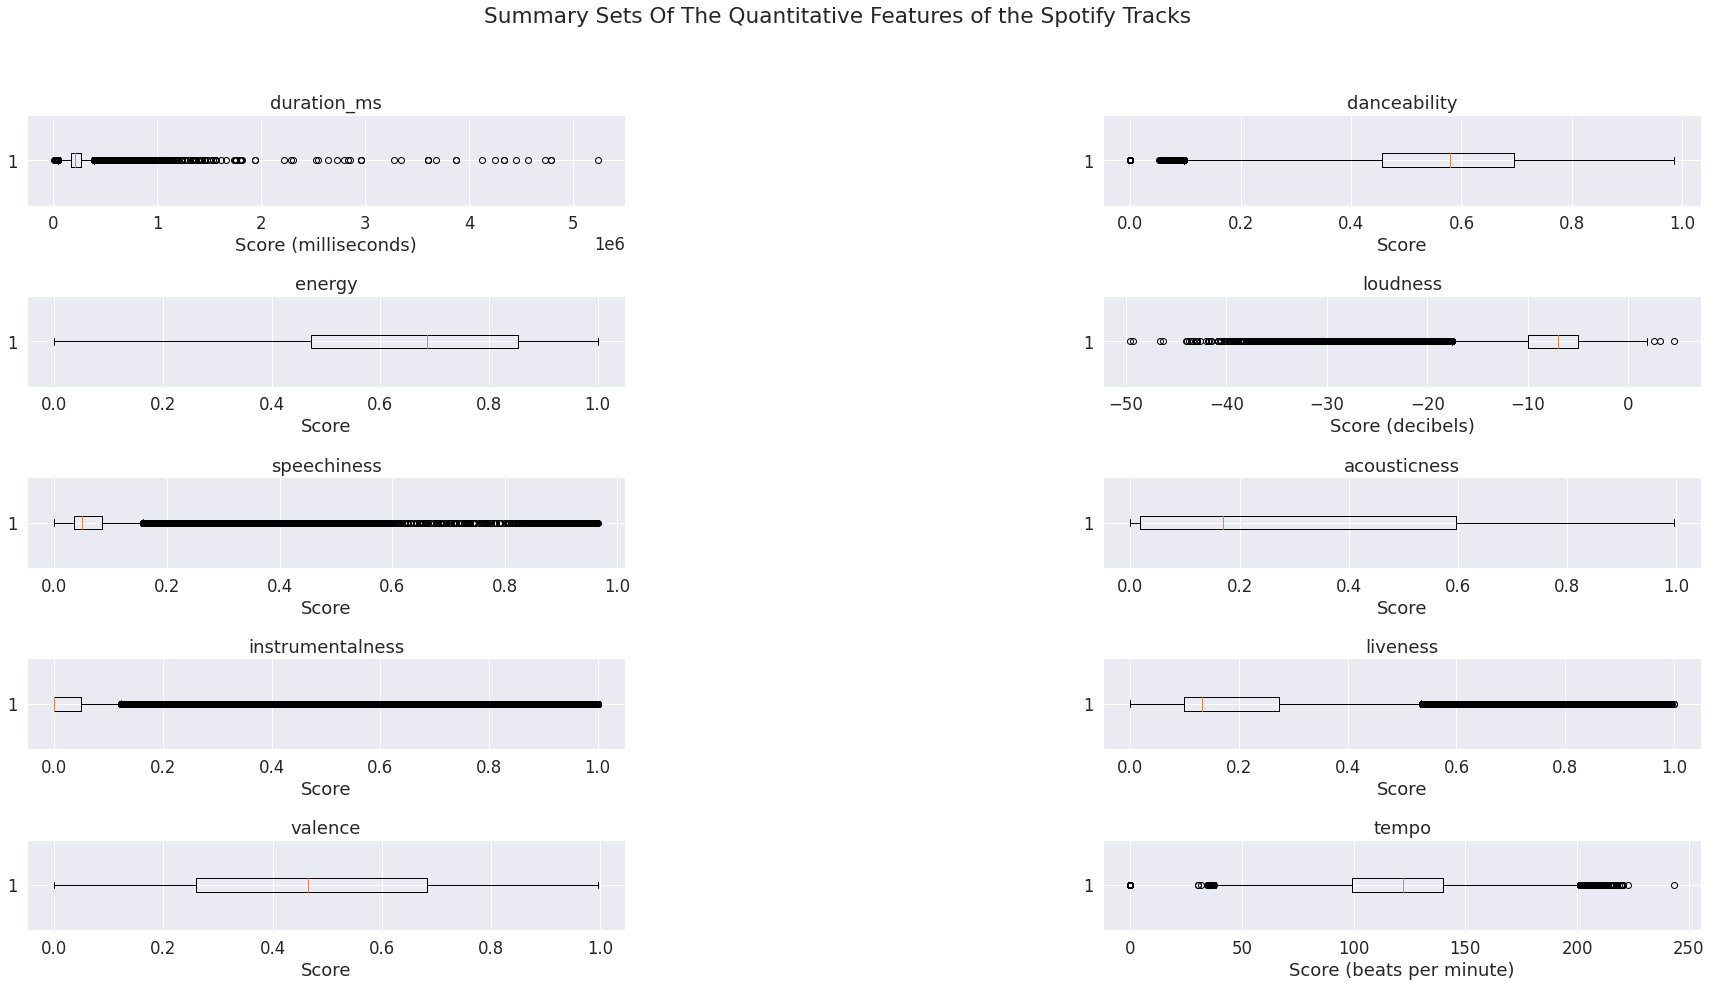

In [ ]:
# set sns 
sns.set(font_scale = 1.5)

# the quantitative, continuous features of each song + labels
quant_cont_feats = ['duration_ms', 'danceability', 'energy', 
                    'loudness', 'speechiness', 'acousticness', 
                    'instrumentalness', 'liveness', 'valence', 
                    'tempo']

# create box and whisker plots for each feature
for i in range(len(quant_cont_feats)):
    plt.subplot(5, 2, i + 1)
    plt.boxplot(df_clean.loc[:, quant_cont_feats[i]].values, vert = 0)
    plt.title(quant_cont_feats[i])

    # use special x labels for listed features
    label_dict = {
        'duration_ms':  '(milliseconds)',
        'loudness':     '(decibels)',
        'tempo':        '(beats per minute)'
    }
    label = 'Score'
    if quant_cont_feats[i] in label_dict:
        label += ' ' + label_dict[quant_cont_feats[i]]
    plt.xlabel(label)

# labeling and formatting plot
plt.suptitle('Summary Sets Of The Quantitative Features of the Spotify Tracks')
plt.gcf().set_size_inches(30, 15)
plt.subplots_adjust(wspace=.8, hspace=1)

In the above visualization, we wanted to characterize the spread of the quantitative, continuous features in the dataset. We decided to use box and whisker plots so we could clearly see if features tended to be symmetrical or skewed throughout the entire dataset, and make other general observations of important measures of center/spread.

**In a box and whisker plot**:

- Each plot summarizes a data set with five marks: one at the end of the left "whisker" (min), one at the left edge of the box (first quartile), one inside the box (median), the other at the right edge of the box (third quartile), and another attached to the right "whisker" (max).
- 50% of the values represented in each box plot fall below the median while the other half fall above. 
- The IQR is the range of points within the box. If a data point is below the value of Quartile 1 - 1.5(IQR), or above the value of Quartile 2 + 1.5(IQR), then the points will be labeled as outliers (the black dots on the graphs)


**Here are some examples of conclusions we can draw from this graph**:
- The median for energy is about 0.68, and all of the energy values range from about 0.0 to 1.0, meaning that 50% of the data has an energy value of 0.68 - 1.0.
- Valence, a measure of how “happy” a song sounds, appeared to be fairly symmetrical, meaning there was a good distribution of happy and sad songs within the dataset.
- Speechiness, instrumentalness, and acousticness are right-skewed as they have a much longer tail and outliers on the right than they do on the left.

#### Visualization 2: Correlation between song traits

Text(0.5, 1.0, 'Correlation Matrix of Various Song Attributes')

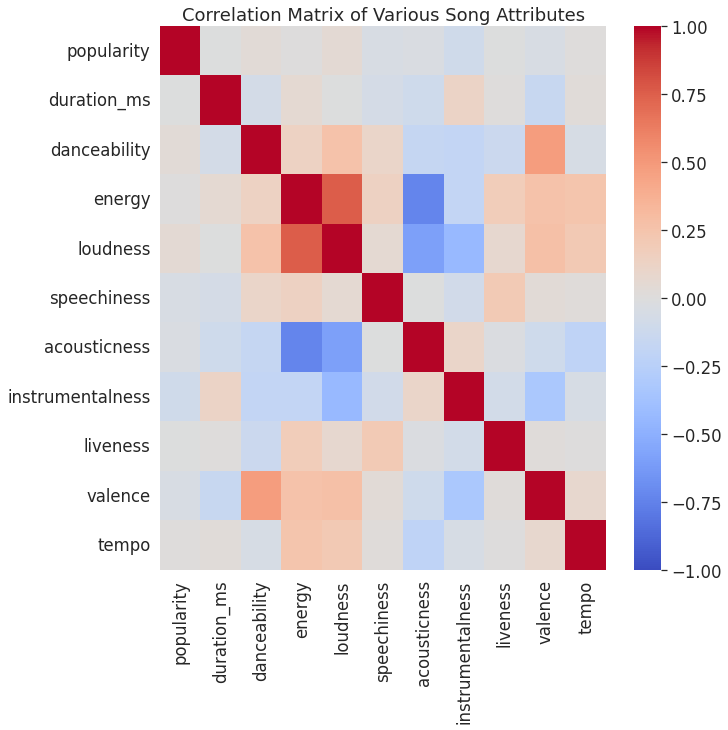

In [ ]:
# list of the quantitative features of each song
# that we want to view the correlation of
quant_feat = ['popularity', 'duration_ms', 'danceability', 
              'energy', 'loudness', 'speechiness', 
              'acousticness', 'instrumentalness', 
              'liveness', 'valence', 'tempo']

# obtain dataframe with only those features
df_corr = df_clean.loc[:, quant_feat]

# plot the correlation matrix
sns.heatmap(df_corr.corr(), vmin=-1, vmax=1, cmap='coolwarm')
plt.gcf().set_size_inches(10, 10)
plt.title('Correlation Matrix of Various Song Attributes')


After characterizing each feature, we wanted to gain a better sense of the relationships between features, so we created a correlation matrix for quantitative features of the songs that would make sense to calculate a correlation for.

**In this correlation matrix:**
-  an intense red color indicates that the two features have a correlation close to +1, meaning that they have a strong positive relationship (ex. As feature A increases, feature B tends to increase as well)
- an intense blue color indicates that the two features have a correlation close to -1, meaning that they have a strong negative relationship (as feature A increases, feature B tends to decrease).

**Notably:**
- The box between the energy and acousticness features is an intense blue, meaning that a song with low energy usually has high acousticness, which makes sense as those songs use softer-sounding instruments that are not electrically amplified. 
- The box between energy and loudness is a strong red color, meaning they have a positive relationship. This suggests that with the increase of energy, loudness also tends to increase.


### Data processing: Top 10 Genres

After cleaning the data and visualizing it overall, we decided to obtain only the tracks from the top 10 genres (based on the average popularity score of all tracks in that genre) to further analyze through ML methods. This is because the original dataset is very large dataset, and it was difficult for us to perform ML methods on it. 

In [ ]:
# group by genre
df_genre_grouped = df_clean.groupby('track_genre').mean()

# select only top 10 genres by popularity
df_top_genre = df_genre_grouped.nlargest(10, 'popularity')

Below is a visualization of the top 10 genres that we obtained by grouping by genre and calculating the average popularity of all the genres in the dataset.

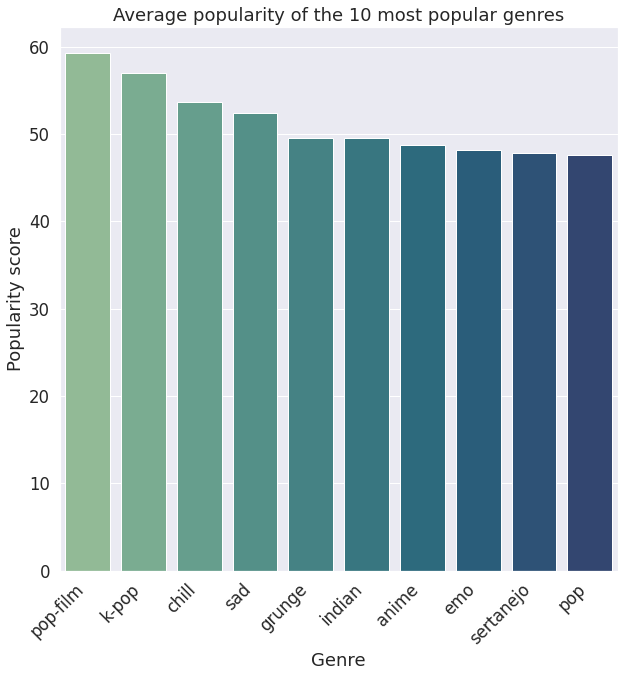

In [ ]:
# obtain genres and popularity scores from grouped df
genres = df_top_genre.index
popularity = df_top_genre.loc[:, 'popularity'].values

# graph to visualize
sns.set(font_scale = 1.5)
sns.barplot(x=genres, y=popularity, palette='crest')
plt.xticks(rotation=45, ha="right")
plt.title('Average popularity of the 10 most popular genres')
plt.xlabel('Genre')
plt.ylabel('Popularity score')
plt.gcf().set_size_inches(10, 10)

We then filtered through the original cleaned dataset to get only the tracks that were a part of these top 10 genres. 

In [ ]:
# get all the tracks in the original data in the 10 most popular genres
df_genre = df_clean[df_clean['track_genre'].isin(df_top_genre.index)]

# previewing the filtered data
df_genre.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
5000,1gUAX2ImxDsB3YDcyxMXlB,美波,カワキヲアメク,カワキヲアメク,71,251933,False,0.541,0.846,6,-2.729,0,0.0551,0.01220,0.000149,0.1630,0.524,129.138,4,anime
5001,1di1C0QI6Y92yZPYn6XYAZ,KANA-BOON,TIME,シルエット,73,240133,False,0.436,0.934,2,-2.685,1,0.0507,0.00001,0.140000,0.3210,0.384,91.481,4,anime
5002,3khEEPRyBeOUabbmOPJzAG,Kenshi Yonezu,KICK BACK,KICK BACK,83,193495,False,0.577,0.941,1,-5.170,1,0.1050,0.00207,0.000003,0.0891,0.292,101.921,4,anime
5003,1rN9QoVxw5U7TJkyaUR8C1,TK from Ling tosite sigure,Fantastic Magic,unravel,73,238360,False,0.508,0.889,7,-2.755,0,0.0862,0.04950,0.000000,0.0984,0.332,135.014,4,anime
5004,23phSRwoMy48rwFpmuAP8q,Yoko Takahashi,残酷な天使のテーゼ/魂のルフラン,残酷な天使のテーゼ,60,247746,False,0.691,0.773,0,-5.244,0,0.0494,0.01740,0.000451,0.1170,0.502,128.162,4,anime


## Method

### Assumptions


- "Danceability" and similar scores are implicitily subjective, sp it is unclear if our dataset captures them in a meaningful way to allow ML processing. In listening to a few songs with high or low "danceability" (or other) scores, we found that these features are mediocre at encapsulating their intended meaning.
- We are also assuming that Spotify is doing its best to classify the genre of each song accurately, even though we have some skepticisms. For instance, Spotify classifies a song by a prominent K-pop group (Enhypen) as anime, even though the song is not featured in an anime show. Our classifier predicts the genre of a song based on its features. Yet, the classifier may not be worth much if even Spotify doesn't classify the genre of its tracks with high accuracy. Furthermore, the value of comparing how our machine clusters tracks versus how Spotify classifies tracks is also endangered if even the latter cannot perform that task well. 
- We are also hoping that the data has not been altered by the person who created the dataset on Kaggle. Otherwise, we would be judging Spotify’s classification abilities unfairly. 
- Finally, we are assuming Spotify's classification algorithms haven't changed since the day the Kaggle source was posted. Otherwise, we could be evaluating Spotify’s outdated algorithms, which would hinder our project’s usefulness in the real world.




### ML methods we used


The first ML tool we used was the [KNN classifier](https://www.researchgate.net/publication/270163293_Application_of_k-Nearest_Neighbour_Classification_in_Medical_Data_Mining) prediction system. This allowed us to predict the genre of a specific song based on the features of the song (ex. danceability, energy, acousticness, etc.). We believe this prediction has some degree of validity since genres are already associated with particular songs. Hence, classes of songs that belong to a particular genre already exist and provide a basis for song classification with our algorithm.

We also used a [clustering](https://neptune.ai/blog/clustering-algorithms) ML tool to group multiple songs with similar features. This can provide a revolutionary representation of groups of similar sounding music, disregarding their genres. So, if a user wants to be introduced to a new song, they can find ones that are similar to a song they already enjoy listening to. It would also be interesting to compare whether the song groups we make are similar to those made by Spotify based on genre. Our classes could differ from that of Spotify based on how much we weigh each feature of a track to determine its similarity to another track.

We did not implement regression because we’re focusing on genres. Genres are a categorical feature of the data, which can’t be well analyzed with this more quantitatively-based machine learning method.


## Results

### ML Method 1: Correlation

In [ ]:
# scale normalize data
df_genre_sn = copy(df_genre)
for col in quant_feat:
  df_genre_sn[col] = df_genre_sn[col] / df_genre_sn[col].std()

In [ ]:
# Display the correlation between quantitative features of a track
df_genre_sn.loc[:, quant_feat].corr()

,popularity,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
popularity,1.000000,0.010148,0.059570,-0.028038,-0.004579,0.009512,0.030851,-0.024663,-0.064142,0.005145,-0.028037
duration_ms,0.010148,1.000000,-0.204368,0.146657,0.128664,-0.163230,-0.042523,-0.165729,-0.006501,0.050745,-0.003187
danceability,0.059570,-0.204368,1.000000,-0.120021,-0.062653,0.196933,0.029069,-0.061810,-0.115758,0.339729,-0.135300
energy,-0.028038,0.146657,-0.120021,1.000000,0.790794,0.059465,-0.660348,-0.309267,0.194356,0.373789,0.201936
loudness,-0.004579,0.128664,-0.062653,0.790794,1.000000,-0.035316,-0.550306,-0.451525,0.144480,0.310133,0.149439
speechiness,0.009512,-0.163230,0.196933,0.059465,-0.035316,1.000000,-0.030150,-0.031102,0.007240,0.099619,0.101713
acousticness,0.030851,-0.042523,0.029069,-0.660348,-0.550306,-0.030150,1.000000,0.220190,-0.030035,-0.135505,-0.172554
instrumentalness,-0.024663,-0.165729,-0.061810,-0.309267,-0.451525,-0.031102,0.220190,1.000000,-0.059225,-0.262942,-0.067158
liveness,-0.064142,-0.006501,-0.115758,0.194356,0.144480,0.007240,-0.030035,-0.059225,1.000000,0.097492,0.040735
valence,0.005145,0.050745,0.339729,0.373789,0.310133,0.099619,-0.135505,-0.262942,0.097492,1.000000,0.074825


As shown by the table above and our correlation matrix, there are existing correlations between the quantitative features of the Spotify tracks. We optimized our clustering by performing dimensionality reduction, thereby normalizing the feature scale. Principal Component Analysis removes correlations between two features, which is why we used it for this project. Furthermore, we are relying on 11 features of a track to cluster it. Principal Component Analysis is also optimal to address this aspect of our project since the technique would adjust the data so that those 11 features are combined into one. From there, we can cluster the songs into categories based on all those features integrated together. Hence, our clustering procedure would be simplified while still capturing most of the variance in the original data. Furthermore, by condensing the 11 features into 1, our machine will utilize less memory. 

#### PCA

Below, we conducted Principal Component Analysis (PCA) to rotate and scale the data, and we built a plotly graph to see the distribution of genres.

In [ ]:
# obtain values of features of interest
x = df_genre_sn.loc[:, quant_feat].values

# compress to PCA
pca = PCA(n_components = 2, whiten = True)
x_compress = pca.fit_transform(x)

# add features back into dataframe (for plotting)
df_genre_sn['pca0'] = x_compress[:, 0]
df_genre_sn['pca1'] = x_compress[:, 1]

# scatter plot the pca data
# each point is color-coded by genre to visualize the differences between 
# Spotify's algorithms and our classifier in organizing the tracks
hover_data = ['track_name', 'artists', 'track_genre'] + quant_feat
px.scatter(df_genre_sn, x = 'pca0', y = 'pca1', hover_data = hover_data, 
           title = 'Spotify tracks', color = 'track_genre')

This graph reduces the dimensionality of the Spotify data to two dimensions, combining the 11 quantitative features. Similar samples are closer together on the scatterplot.

#### Optimizing cluster number


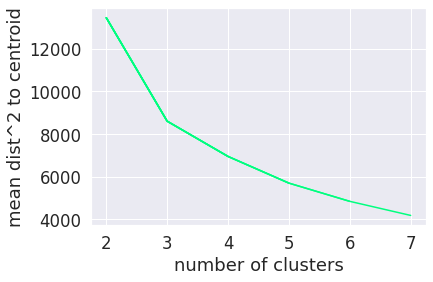

In [ ]:
# keys are k (number of clusters), values are mean_d (mean distance
# from each sample to its cluster centroid)

mean_d_dict = dict()
for n_clusters in range(2, 8):
    # fit kmeans
    kmeans = KMeans(n_clusters = n_clusters)
    kmeans.fit(x_compress)
    y = kmeans.predict(x_compress)  
        
    # compute & store mean distance
    mean_d = -kmeans.score(x_compress)
    mean_d_dict[n_clusters] = mean_d

    # plot the mean distances from each sample to its cluster centroid when 
    # using 2 to 7 sub-groups
    plt.plot(list(mean_d_dict.keys()), list(mean_d_dict.values()), 
             color = 'springgreen')
    plt.xlabel('number of clusters')
    plt.ylabel('mean dist^2 to centroid')

3 appears to be a good number of clusters for the Spotify single data because that is where the "elbow" is on the above graph. Having 3 clusters limits the mean distances from each sample to its centroid much more than if there were only 1 or 2 clusters. Furthermore, the decrease in mean distances from each sample to its centroid from with 3 clusters to 4 isn't too sigificant, so having 4 or more clusters might unnecessarily overcomplicate the clustering process.

#### Clustering

In [ ]:
# keys are k (number of clusters), values are mean_d (mean distance
# from each sample to its cluster centroid)
mean_d_dict = dict()
n_clusters = 3

# fit kmeans
kmeans = KMeans(n_clusters = n_clusters)
kmeans.fit(x_compress)
y = kmeans.predict(x_compress)   
df_genre_sn['cluster'] = y

# unpack df_compress coordinates into df_single_sn columns
df_compress = pd.DataFrame(x_compress)
df_genre_sn['compress0'] = df_compress[0]
df_genre_sn['compress1'] = df_compress[1]

# compute & store mean distance
mean_d = -kmeans.score(x_compress)
mean_d_dict[n_clusters] = mean_d

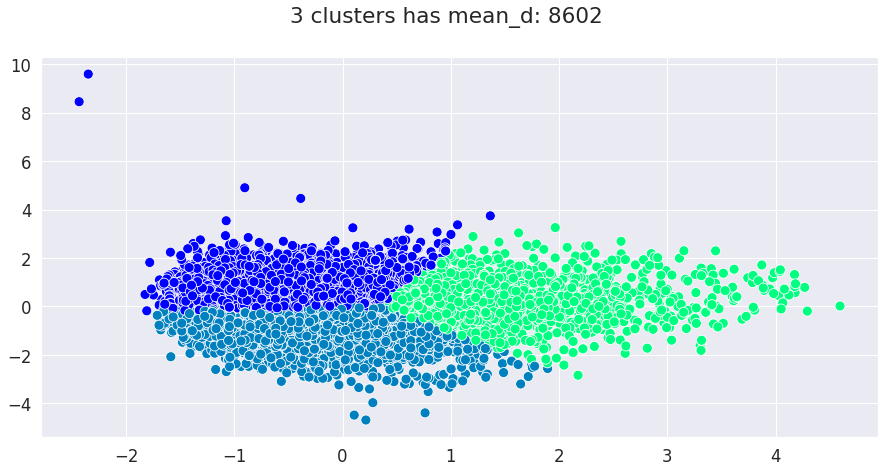

In [ ]:
# plot clustering
plt.figure()
sns.scatterplot(x = x_compress[:, 0], y = x_compress[:, 1], s = 100, hue = y, 
                palette = 'winter')
plt.suptitle(f'{n_clusters} clusters has mean_d: {mean_d:.0f}')
plt.gca().get_legend().remove()
plt.gcf().set_size_inches(15, 7)

The above graph represents the clusters that the ML method determined would fit the data the best. In other words, the graph represents how the machine thinks is the best way to organize the tracks into 3 groupings.


#### Presenting how the machine clusters the Spotify tracks

To further evaluate the effectiveness of the clusters, we wanted to learn more about the songs at the center of each cluster to see if they sounded similar or had similar genres. We wrote the following code to extract the center of each cluster and the 5 closest songs to that center. 

In [ ]:
# Determines the positions corresponding to the centroids in the model
centroids = list(kmeans.cluster_centers_)
centroids = [tuple(coordinates) for coordinates in centroids]

In [ ]:
for centroid in centroids:

  close_tracks = {'track_name': [], 'artists': [], 'track_genre': [], 
                  'distance': []}
  close_tracks = pd.DataFrame(close_tracks)
  min_dist_to_centroid = float('inf')

  # Calculates the distance between a point representing a track and a centroid
  for idx, row in df_genre_sn.iterrows():
    dist_to_centroid = distance.euclidean(row['compress0':'compress1'],
                                          centroid)
    new_row = {'track_name': [row['track_name']], 'artists': [row['artists']], 
               'track_genre': [row['track_genre']], 
               'distance': [dist_to_centroid]}
    new_row = pd.DataFrame.from_dict(new_row)
    close_tracks = pd.concat([close_tracks, new_row], ignore_index = True)

  # Sort the tracks into a dataframe based on their distance to a centroid
  close_tracks = close_tracks.sort_values(by = 'distance')
  # Displays the track with the point closest to a centroid
  print('\nTrack Closest to Centroid:\n', close_tracks['track_name'].iloc[0], 'by', 
        close_tracks['artists'].iloc[0])
  print('Centroid Track Genre:', close_tracks['track_genre'].iloc[0])
  print('Distance to Centroid:', close_tracks['distance'].iloc[0])

  print('\nNext closest songs:\n')

  # Displays the 5 tracks with points closest to the "centroid track" point
  for i in range(1, min(6, len(close_tracks))):
    # print(i)
    # print(len(close_tracks))
    print(close_tracks['track_name'].iloc[i], 'by', 
          close_tracks['artists'].iloc[i])
    print('Track Genre:', close_tracks['track_genre'].iloc[i])
    print('Distance to Centroid:', close_tracks['distance'].iloc[i], '\n')


Track Closest to Centroid:
 awake by Taku Iwasaki
Centroid Track Genre: anime
Distance to Centroid: 0.08952515219864055

Next closest songs:

Suzume (From "Suzume no Tojimari") - Orchestral Lullaby Version by Pharozen
Track Genre: anime
Distance to Centroid: 0.12567509875349 

"DEVILS NEVER CRY"(スタッフロール) by Capcom Sound Team
Track Genre: anime
Distance to Centroid: 0.14081709382387747 

Rainy Day by Kato
Track Genre: anime
Distance to Centroid: 0.14427630476040862 

Gurenge but is it okay if it's lofi? by Kijugo
Track Genre: anime
Distance to Centroid: 0.1745209682689243 

Chala Head Chala (DBZ) by Otaku
Track Genre: anime
Distance to Centroid: 0.18773288046959055 


Track Closest to Centroid:
 Departures 〜あなたにおくるアイの歌〜 by EGOIST
Centroid Track Genre: anime
Distance to Centroid: 0.05647750031558908

Next closest songs:

chAngE by miwa
Track Genre: anime
Distance to Centroid: 0.058791249862427564 

Tamed-Dashed by ENHYPEN
Track Genre: anime
Distance to Centroid: 0.061933874268539184 

う

### ML Method 2: KNN classification

How good can ML be at predicting the genre of a song based on its quantitative features?

#### Optimize K value


In [ ]:
def get_cv_acc_knn(x, y, k, n_splits = 10):
    """ computes cross validated accuracy of a KNN classifier
    
    Args:
        x (np.array) = (n_sample, n_feat) features
        y (np.array) = (n_sample) target variable
        k (int) = num nearest neighbors in knn classifier
        n_splits (int) = number of folds
        
    Returns: acc (float): cross validated accuracy
        
    """
    # initialize knn classifier
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    
    # stratify to ensure same ratio of species across folds
    kfold = KFold(n_splits=n_splits, shuffle = True)
    
    # initialize empty array to hold y_pred values
    y_pred = np.empty_like(y)
    for train_idx, test_idx in kfold.split(x, y):
        # split test and training data
        x_train = x[train_idx, :]
        x_test = x[test_idx, :]
        y_true_train = y[train_idx]
    
        # train on training data
        knn_classifier.fit(x_train, y_true_train)
        
        # predict on the testing data
        y_pred[test_idx] = knn_classifier.predict(x_test)
        
    # return accuracy score of y_pred when compared to y_true
    return accuracy_score(y, y_pred)
    

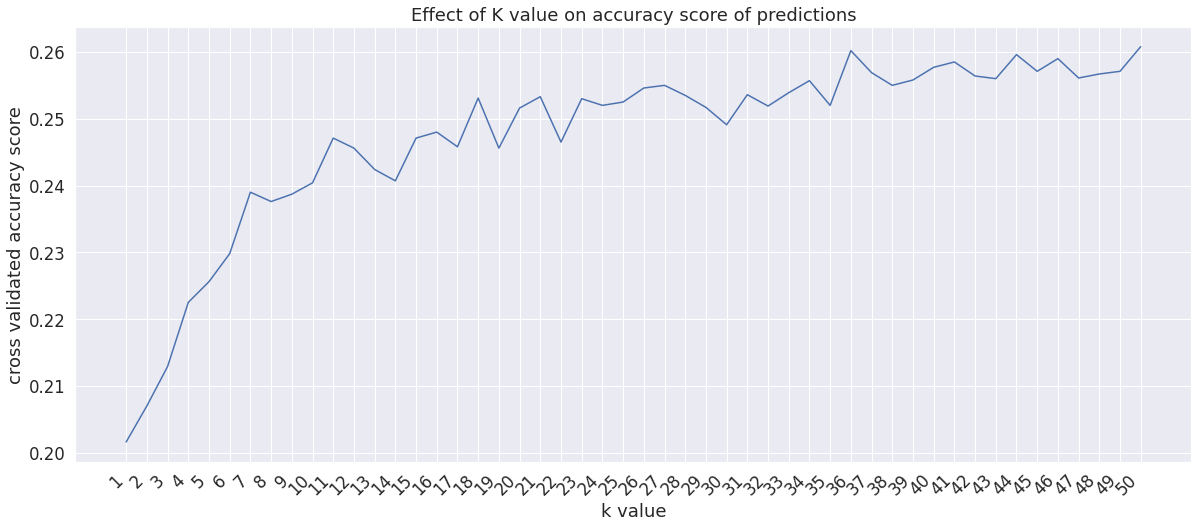

In [ ]:
# set up training data (with scale normalized data)
x = df_genre_sn.loc[:, quant_feat].values
y_feat = 'track_genre'
y_true = df_genre.loc[:, y_feat].values

# initialize list to keep track of accuracy values
accuracy_list = list()
for k in range(1, 51):
    # get accuracy values for k values from 1 to 50
    accuracy = get_cv_acc_knn(x_compress, y_true, k)
    accuracy_list.append(accuracy)

# plot a graph of accuracy vs k value
plt.plot(range(1, 51), accuracy_list)
plt.xlabel('k value')
plt.xticks(range(1, 51))
plt.ylabel('cross validated accuracy score')
plt.title('Effect of K value on accuracy score of predictions')
plt.xticks(rotation=45, ha="right")
plt.gcf().set_size_inches(20, 8)


The above graph shows us how classifiers using a different number of k-nearest neighbors performed (based on their overall accuracy score). A K of 35 displayed the highest accuracy, so that's what we chose.


Note: This graph changes every time we run the cell, because of subtle differences in the way each classifier runs. So, the exact K in the graph above that resulted in the highest accuracy score may be slightly different than 35. We felt it was fine to use 35 as our K because the accuracy scores were similar enough. 


#### Classifier

In [ ]:
# initialize a knn_classifier
knn_classifier = KNeighborsClassifier(n_neighbors=34)

# construction of kfold object
kfold = KFold(n_splits=10, shuffle = True)

# allocate an empty array to store predictions in
y_pred = copy(y_true)

for train_idx, test_idx in kfold.split(x, y_true):
    # build arrays which correspond to x, y train /test
    x_test = x[test_idx, :]
    x_train = x[train_idx, :]
    y_true_train = y_true[train_idx]
        
    # fit classifier
    knn_classifier.fit(x_train, y_true_train)

    # estimate each song's genre
    y_pred[test_idx] = knn_classifier.predict(x_test)

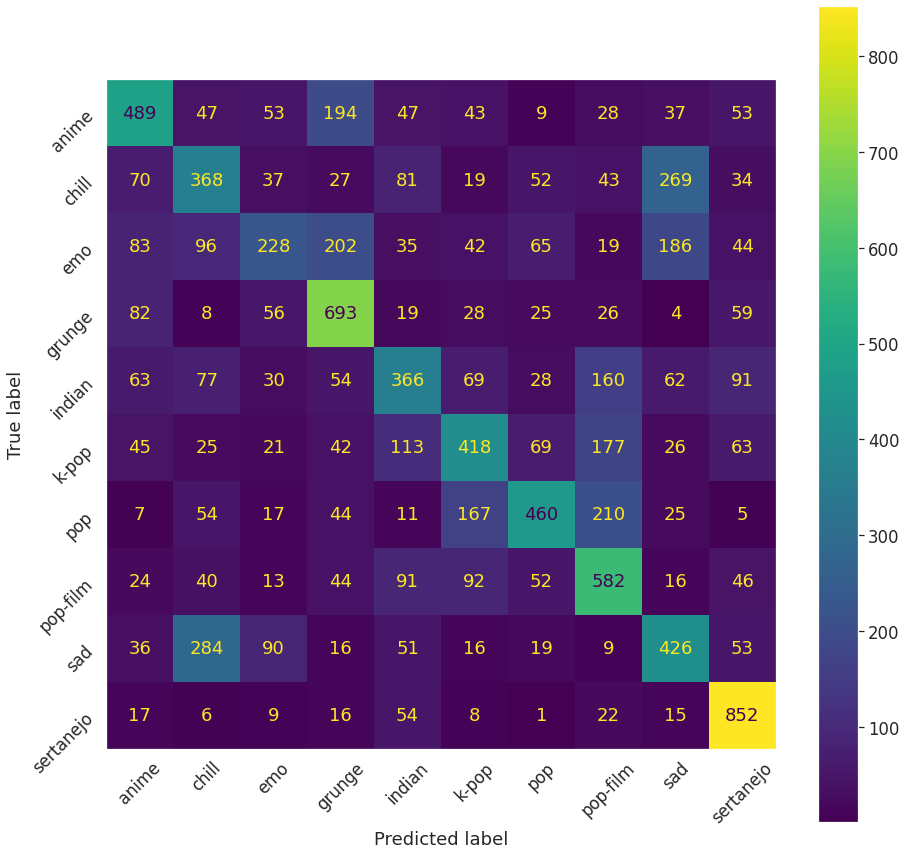

In [ ]:
# obtain and plot the confusion matrix
conf_mat = confusion_matrix(y_true=y_true, y_pred=y_pred)
conf_mat_disp = ConfusionMatrixDisplay(conf_mat, display_labels=np.unique(y_true))
conf_mat_disp.plot()
plt.gcf().set_size_inches(15, 15)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.grid(False)

In [ ]:
# calculate accuracy score of classifier
accuracy_score(y_true, y_pred)

0.4882488248824883

Here is a visualization of the confusion matrix of the classifier. It displays whether the classifier predicted a specific genre correctly, and if not, which genre it was confused for. A brighter box in the diagonal of the matrix indicates that the classifier predicted that genre correctly more often.

Some interesting points:
- The classifier frequently confused sad music for emo music, and sad music for chill music
- Indian, chill, and sad music were the songs that were most often classified incorrectly 

## Discussion

### Interpretation

The PCA graph shows that the genres overlap heavily, which means that multiple genres have similar features. This graph made us think that the clustering wouldn’t be successful at emulating genre groupings since the genres overlapped so much. 

When we clustered, as we expected, the data itself doesn’t really group into natural clusters, and it seems like clustering is not really an effective machine learning model for our project. Additionally with our clustering, we found it interesting that all the centroid songs were anime. This aspect of our project made us suspicious about our clustering results. We initially removed all duplicate instances of a track from the dataset, but it turns out that each duplicate entry of a track identifies the same song with a different genre. Hence, we thought our data cleaning caused all of our centroid songs to have the same genre if the first instance of each song in the dataset happened to have the same genre. Yet, even after testing our machine with the duplicates and shuffling our songs, all of our centroid songs still happened to be anime. So, we believe that this just further shows how spread out Spotify’s genres can be; the anime genre itself spans all 3 clusters.

With the classifier, the diagonal of our confusion matrix was fairly bright, indicating the classifier works fairly well with an accuracy score of about 49%. We think that some genres were better classified than others because they may have more distinct features. For example, perhaps sertanejo is a very distinct genre with regards to its features, which resulted in it being classified correctly most of the time. Additionally some of the mistakes it made often make sense. For example, it frequently confused sad music for emo and chill music. These are genres that are similar and would probably have similar features.

Overall, we believe that our results show that genre is a surprisingly difficult thing to predict. The classifier was okay, but the clustering didn’t really make much sense. And even when we played songs right next to each other in the clustering graphs, they sounded so different to us. This poor clustering was expected considering the amount of subjectivity that defines a song’s genre. Experts in the field of music might agree that music cannot clearly be organized objectively into categories since it’s such a multilayered art.

Our results suggest that Spotify’s metrics may be flawed. Worse, songs may not be given a representative score for their features, partially because it’s so hard to actually quantify a song’s “danceability” or “acousticness." Additionally, even if every song was given a perfect number for all its features, it’s difficult to quantify a genre based on numerical factors. As we saw in the PCA graph, genres have too much overlap.

Therefore, these results should not be accepted at face value. Genres are somewhat arbitrary to begin with. It’s hard to classify songs themselves into distinct genres - each song is unique, and doesn’t always neatly fit into one category. It’s hard to determine how accurate Spotify’s metrics are when there’s no right answer regarding the genre label a song should receive. Perhaps our project would yield more conclusive results if we were testing Spotify’s ability to classify a more objective feature of a song, such as loudness or tempo.


### Future Analysis

It would be interesting to collect more data from actual people in the future to observe the differences between how Spotify, our machine, and actual humans classify songs. The first two sort songs very objectively, but there is no one way to correctly interpret music. Emphasizing the discrepancies between how each group a song could highlight how powerful the human heart is when it comes to emotionally connecting with the layers of any artistic piece. This kind of analysis could even be inspiring for those who worry that robots will take over the world. However, people who take these actions should ensure to collect a representative human sample. Collecting data from individuals from all walks of life would lessen the chance that the classification methods of Spotify and our machine are compared with those of specific types of individuals.

Furthermore, even though Spotify is definitely the most popular streaming service right now, there are others too with their own algorithms. We could compare how flawed Spotify’s algorithms are compared to those of other streaming platforms such as Apple Music, Pandora, and YouTube Music. This comparison could maybe provide insight as to why Spotify is so highly favored among the streaming services that exist today. The only potential setback with this approach is that genre classification is very subjective. One may argue that one streaming service better classifies a song's genre than the other based on their perceptions of a genre. Nevertheless, it would still be interesting comparing the features used by Spotify to classify its tracks compared to those of other streaming platforms.

We could have tried to make a clustering ML tool to group multiple artists together who have songs with similar features. This can be a good representation of all the artists that produce similar music. So, if a user wants to be introduced to new artists, they can find ones that are similar to an artist they already like listening to. It would also be interesting to compare whether the artist groups we make are similar to those made by Spotify. Spotify contains playlists for certain artists that also feature artists that the company’s algorithms believe produce similar music. Our classes could differ from that of Spotify based on how much we weigh each feature of a track to determine its similarity to another track.

The project also lends itself to opportunities to explore which quantitative features are the most important in determining a song’s category. We could have used a random forest classifier and analyzed its associated feature importance graph to understand the features that Spotify’s machine prioritizes in sorting songs into specific playlists. We didn’t have enough time to manually include all of the playlists associated with each track in our CSV file, but there are probably ways for that process to be completed in an efficient manner that we just unfortunately did not encounter. If we could have successfully done so, then we could have made a classifier that uses the quantitative features of a song to predict the playlists it is found in. We don't think there are any ethical implications involved with this analysis, but a possible issue could be how Spotify's playlists change all the time. Therefore, we would need a way for people who work on this project to work with live data that monitors the playlists a song exists in every day.